In [ ]:
import PIL.Image
%load_ext autoreload
%autoreload 2

In [ ]:
import torch

from configs.ve.cifar10_ncsnpp_deep_continuous import get_config
from score_inverse.models.utils import create_model
from score_inverse.models.ema import ExponentialMovingAverage

In [ ]:
config = get_config()
config.model.num_scales = 100  # Number of discretisation steps
config.eval.batch_size = 1  # Number of samples per generation


ckpt_path = "checkpoints/ve/cifar10_ncsnpp_deep_continuous/checkpoint_12.pth"
loaded_state = torch.load(ckpt_path, map_location=config.device)

score_model = create_model(config)
# Still need to load the base model state since non-trainable params aren't covered by EMA
score_model.load_state_dict(loaded_state["model"], strict=False)

# Replace trainable model params with EMA params
ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
ema.load_state_dict(loaded_state["ema"])
ema.copy_to(score_model.parameters())

In [ ]:
from score_inverse.sde import get_sde
from score_inverse.datasets.scalers import get_data_inverse_scaler
from score_inverse.sampling import get_sampling_fn

inverse_scaler = get_data_inverse_scaler(config)
sde, sampling_eps = get_sde(config)

sampling_shape = (
    config.eval.batch_size,
    config.data.num_channels,
    config.data.image_size,
    config.data.image_size,
)
sampling_fn = get_sampling_fn(config, sde, sampling_shape, inverse_scaler, sampling_eps)

In [ ]:
from PIL import Image
import numpy as np


def display_img(im, scale=10):
    w, h = im.size
    display(im.resize((scale * w, scale * h), Image.NEAREST))


def display_sample(sample, scale=10, shape=None):
    samples = np.clip(sample.permute(0, 2, 3, 1).cpu().numpy() * 255.0, 0, 255).astype(
        np.uint8
    )
    if shape is None:
        shape = (
            -1,
            config.data.image_size,
            config.data.image_size,
            config.data.num_channels,
        )
    samples = samples.reshape(shape)
    im = Image.fromarray(samples[0])
    display_img(im, scale)

In [ ]:
sample, n = sampling_fn(score_model)

In [ ]:
display_sample(sample)

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchdrift.data.functional import shot_noise
from functools import partial
import matplotlib.pyplot as plt

In [46]:
noiser = transforms.Compose([
    transforms.ToTensor(),
    partial(shot_noise, severity=1),
    partial(torch.clamp, min=0, max=255) # this probably isn't necessary, but clip just in case
])
blurrer = transforms.Compose([
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=3)
])

cifar10 = {
    'train': {
        'truth': datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=transforms.ToTensor()),
        'noised': datasets.CIFAR10('./CIFAR10', train=True, download=False, transform=noiser),
        'blurred': datasets.CIFAR10('./CIFAR10', train=True, download=False, transform=blurrer)
    },
    'test': {
        'truth': datasets.CIFAR10('./CIFAR10', train=False, download=False, transform=transforms.ToTensor()),
        'noised': datasets.CIFAR10('./CIFAR10', train=False, download=False, transform=noiser),
        'blurred': datasets.CIFAR10('./CIFAR10', train=False, download=False, transform=blurrer)
    }
}

Files already downloaded and verified


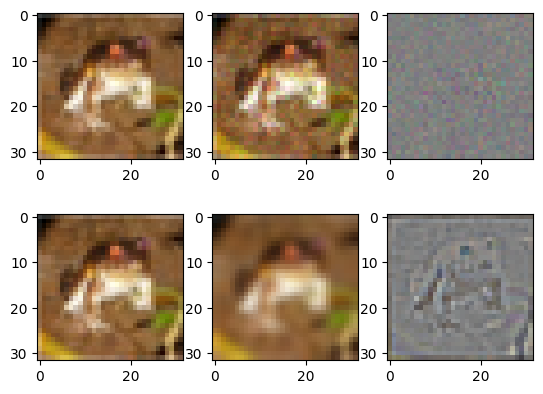

In [91]:
_, axs = plt.subplots(2,3)

i = 0

axs[0,0].imshow(cifar10['train']['truth'][i][0].movedim(0,-1))
axs[0,1].imshow(cifar10['train']['noised'][i][0].movedim(0,-1))
axs[0,2].imshow(cifar10['train']['noised'][i][0].movedim(0,-1) - cifar10['train']['truth'][i][0].movedim(0,-1) + 0.5)

axs[1,0].imshow(cifar10['train']['truth'][i][0].movedim(0,-1))
axs[1,1].imshow(cifar10['train']['blurred'][i][0].movedim(0,-1))
axs[1,2].imshow(cifar10['train']['blurred'][i][0].movedim(0,-1) - cifar10['train']['truth'][i][0].movedim(0,-1) + 0.5)

plt.show()

In [86]:
noised_train = datasets.CIFAR10('./CIFAR10', train=True, download=False, transform=noiser, target_transform=transforms.ToTensor())
noised_train.targets = noised_train.data
noised_test = datasets.CIFAR10('./CIFAR10', train=False, download=False, transform=noiser, target_transform=transforms.ToTensor())
noised_test.targets = noised_test.data

blurred_train = datasets.CIFAR10('./CIFAR10', train=True, download=False, transform=blurrer, target_transform=transforms.ToTensor())
noised_train.targets = noised_train.data
blurred_test = datasets.CIFAR10('./CIFAR10', train=False, download=False, transform=blurrer, target_transform=transforms.ToTensor())
blurred_test.targets = blurred_test.data

In [87]:
batch_size=64

noised_train_loader = DataLoader(noised_train, batch_size=batch_size, shuffle=True)
noised_test_loader = DataLoader(noised_test, batch_size=batch_size, shuffle=True)

blurred_train_loader = DataLoader(blurred_train, batch_size=batch_size, shuffle=True)
blurred_test_loader = DataLoader(blurred_test, batch_size=batch_size, shuffle=True)